# Conflicts factorization

In this notebook, we will try to find hidden informations in our dataset. We want to find meaningful information among the conflicts in the world through years.

This dataset will use Matrix Factorization to enhance our latent space.

In [1]:
import requests
import json
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

## Data Handling

> TO DO LIST

- Drop all non-necessary columns. 
- Create vector containing interesting countries
- Separate dates

In [2]:
colonies_df = pd.read_csv('datasets/colonies_wikipedia.csv')
conflicts_df = pd.read_csv('datasets/clean_conflict.csv')

# Separate Datetime
conflicts_df['time'] = pd.to_datetime(conflicts_df['ependdate'])   
conflicts_df['year'] = conflicts_df.time.dt.year
conflicts_df['month'] = conflicts_df.time.dt.month
conflicts_df['day'] = conflicts_df.time.dt.day

# Drop non-necessary columns
conflicts_df.drop([list(conflicts_df)[0], 'conflictid','sidebid','incomp', 'cumint'\
                    ,'type','ISO2', 'ependdate','day','time'], axis = 1, inplace = True)
colonies_df.drop(['ID','Day','URL'],axis = 1, inplace = True)


colonies_df = colonies_df.dropna(0)
conflicts_df = conflicts_df.dropna(0)

In [3]:
colonies_df['Colonized Country'].replace('Republic of Tunisia','Tunisia')
colonies_df['Colonized Country'].replace('Congo','Republic of the Congo')
colonies_df['Colonized Country'].replace('DR Congo','Congo')
colonies_df['Colonized Country'].replace('Independent State of Papua New Guinea','New Guinea')
colonies_df.head()

,Unnamed: 0,Colonized Country,Month,Year,Colonizer Country
0,1,Iceland,6,1944,Denmark
1,2,Canada,7,1867,United Kingdom
2,3,United States,7,1776,France
3,4,Haiti,1,1804,France
4,5,Benin,8,1960,France


In [4]:
colonisation_countries = colonies_df['Colonized Country'].values
colonizers = ['France', 'United Kingdom', 'Denmark', 'Italy', 'Belgium', 'Spain', 'Portugal', 'Russia']
colonisation_countries = np.concatenate([colonisation_countries, colonizers])

## Matrix Creation

In [5]:
min_year = 1946
max_year = 2017
matrix = np.zeros((colonisation_countries.shape[0],max_year - min_year))
total_length = matrix.shape[0]*matrix.shape[1]

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        inter_df = []
        country = colonisation_countries[i]
        date = j +min_year
        inter_df = conflicts_df[conflicts_df['location'].str.contains(country)]
        
        if inter_df.empty:
            inter_df = conflicts_df[conflicts_df['terr'].str.contains(country)]
            
            if inter_df.empty:
                inter_df = conflicts_df[conflicts_df['sidea'].str.contains(country)]
        
        matrix[i][j] = inter_df[inter_df['year'] == date].count().values[1]      

/Users/neuro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()
/Users/neuro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
/Users/neuro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


## Matrix Factorization

In [6]:
model = NMF(n_components = 1000, init='random', random_state=0)

W = model.fit_transform(matrix)
H = model.components_

print ("Reconstruction error = ", 100*mean_squared_error(matrix.flatten(),W.dot(H).flatten()), "%")

Reconstruction error =  8.32969220779e-08 %


## Results & Observations

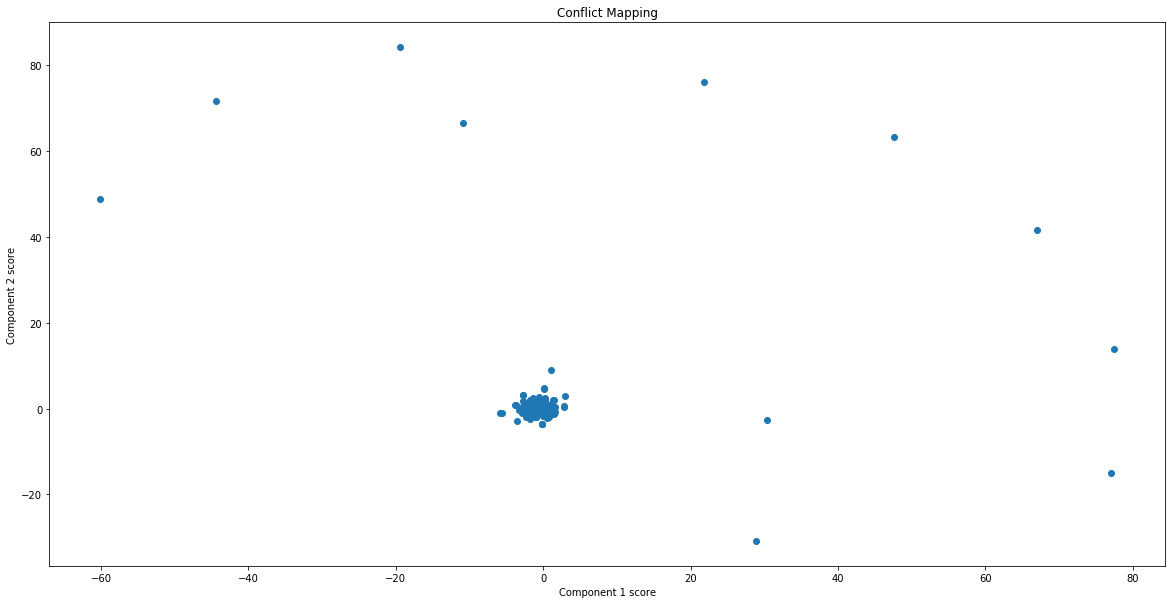

In [7]:
W_embedded = TSNE(n_components=2).fit_transform(W)
H_embedded = TSNE(n_components=2).fit_transform(H)

plt.figure(1, figsize = [20,10])
plt.title("Conflict Mapping")

plt.xlabel("Component 1 score")
plt.ylabel("Component 2 score")

plt.scatter(W_embedded[:,0], W_embedded[:,1])

#plt.savefig('img/factorization_1000components_nocolor.png')
plt.show()

_First observation._

We observe a dense cluster surrounded by a 'crown' of conflicts in this representation. It would become interesting to add the color of the continent for each datapoint.

In [8]:
def color_dict(x):
    return {
    1946<x<1960 : 'blue',
    1959<x<1965 : 'green',
    1965<x<1975 : 'red',
    1974<x<1985 : 'yellow',
    1984<x<1995 : 'black',
    2004<x<2017 : 'purple'}

In [42]:
color_dict = {
    1 : 'blue',
    2 : 'green',
    3 : 'red',
    4 : 'yellow',
    5 : 'black'
    }

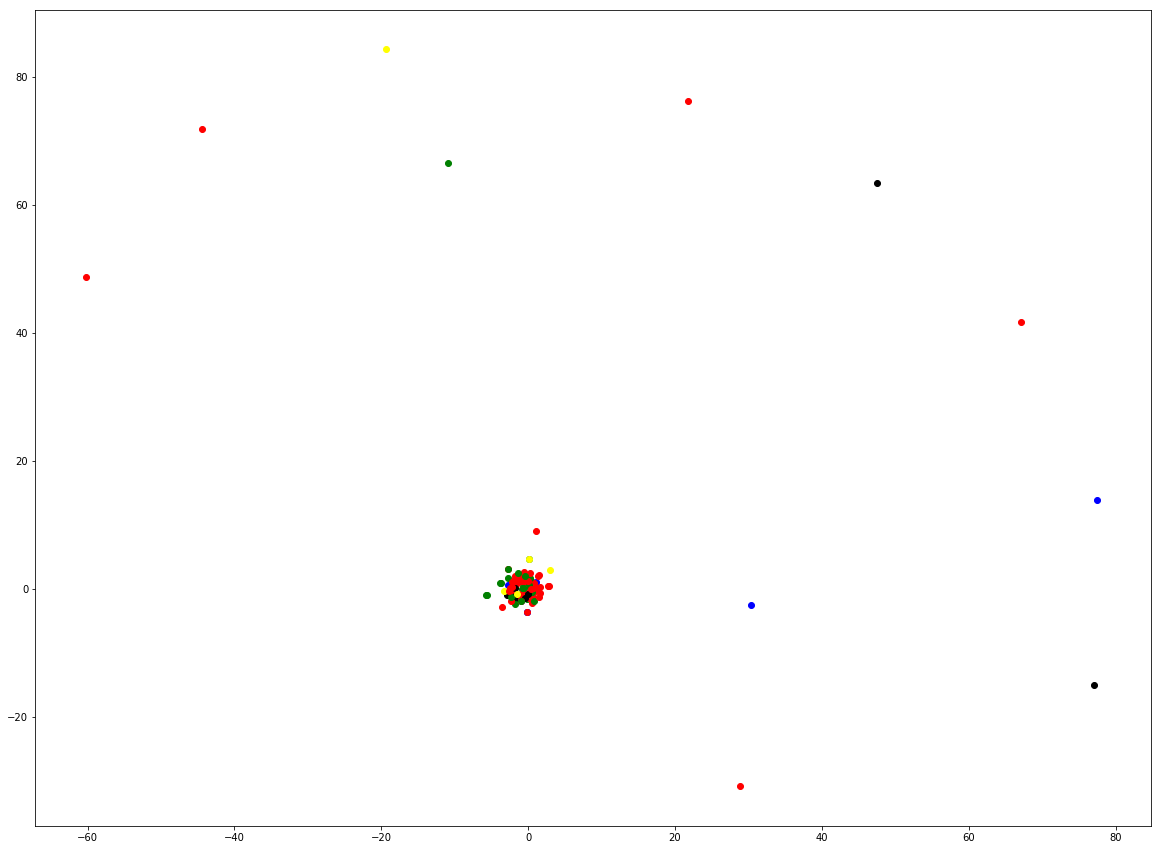

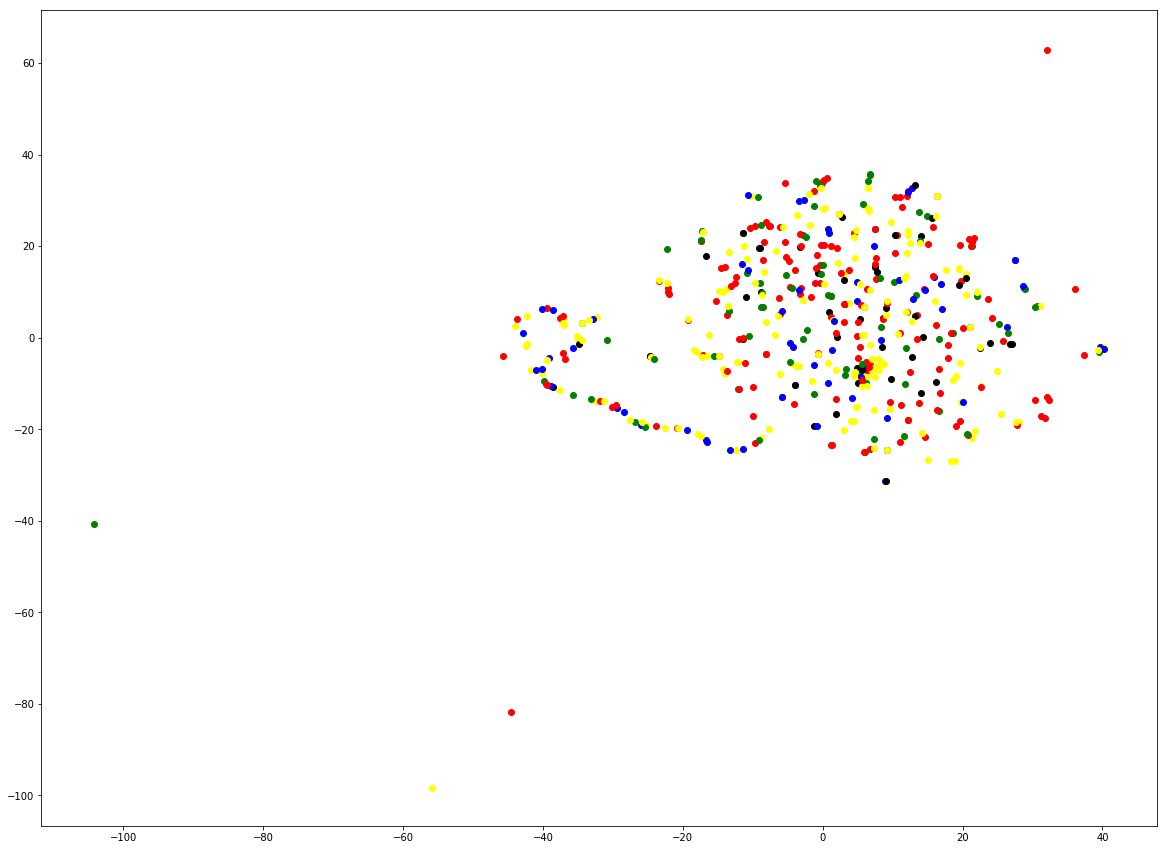

In [47]:
plt.figure(figsize = [20,15])
for i,c in enumerate(conflicts_df['year']):
    sys.stdout.write("Current enumeration: %d   \r" % (i) )
    sys.stdout.flush()
    
    region = conflicts_df['region'].iloc[i]
    if region == '1, 3' or region == '1, 2' or region == '1, 4' or region == '1, 5' or region == '1, 2, 3, 5' or region == '1, 3, 5':
        region = 1
    plt.scatter(H_embedded[:,0][i], H_embedded[:,1][i], c = color_dict[int(region)])
#plt.scatter(W_embedded[:,0][i], W_embedded[:,1][i], c = color_dict(i)[0])
plt.show()

Problème : J'associe un point pour plusieurs conflits d'un même pays sur une même année. Pour bien faire il me faudrait une nouvelle liste de chaque pays avec son continent associé...

In [41]:
matrix.shape

(132, 71)